# 简介

赛题链接：https://challenge.xfyun.cn/topic/info?type=Ad-click-through

## 赛事背景

广告点击率预估是在线广告交易的核心环节之一，如果说一家公司想知道 CTR（点击率），以确定将他们的钱花在数字广告上是否值得。点击率高表示对该特定广告系列更感兴趣，点击率低可能表明广告可能不那么相关。高点击率表明更多人点击了网站，这有利于在谷歌、必应等在线平台上以更少的钱获得更好的广告位置。

近年来，各大有关广告点击率预估的比赛相拥而至，如腾讯广告算法大赛、科大讯飞营销算法大赛、阿里妈妈点击率预估大赛等。可以看出这是一个企业长期关注的问题，也是值得花时间探索的问题。

## 赛事任务
平台展示给用户特定的广告，用户存在点击与不点击两种行为。给定某平台实际广告业务中的用户行为数据，共包含13个用户相关的字段，其中isClick字段表明用户是否会点击广告。

任务目标是通过训练集训练模型，来预测测试集中isClick字段的概率结果，即用户点击平台所推荐广告的概率，以此为依据，表示用户对特定广告感兴趣的程度。

## 评审规则

1. 数据说明

赛题数据由训练集和测试集组成，包含13个特征字段，6天的数据。其中39万多条作为训练集（7月2-6日），7万多条作为测试集（7月7日），同时会对部分字段信息进行脱敏。


<img src="./pic/data.png" width = "300" height = "150" alt="data" align=center />
 

2. 评估指标

本次竞赛的评价标准采用AUC指标，正样本为1，评估代码参考：


In [ ]:
from sklearn.metrics import roc_auc_score
y_true = [0, 1, 0, 1, 1, 1]
y_pred = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
score = roc_auc_score(y_true, y_pred)


3. 评测及排行

1、赛事提供下载数据，选手在本地进行算法调试，在比赛页面提交结果。

2、每支团队每天最多提交3次。

3、排行按照得分从高到低排序，排行榜将选择团队的历史最优成绩进行排名。

## 作品提交要求

文件格式：预测结果文件按照csv格式提交

文件大小：无要求

提交次数限制：每支队伍每天最多3次

预测结果文件详细说明：

1) 以csv格式提交，编码为UTF-8，第一行为表头；

2) 提交前请确保预测结果的格式与sample_submit.csv中的格式一致。具体格式如下：



In [ ]:
id,isClick

463291,0.5

463292,0.5

## 赛程规则

正式赛

8月9日——9月8日

初赛截止成绩以团队在初赛时间段内最优成绩为准（不含测试排名）。

初赛作品提交截止日期为9月8日17:00；正式赛名次公布日期为9月9日10:00。

长期赛

9月9日——10月24日

因赛事以学习实践为主，正式赛将转变为长期赛，供开发者学习实践。本阶段提交后，系统会根据成绩持续更新榜单，但该阶段榜单不再进行公示和奖励。

六、奖项设置
本赛题设立一、二、三等奖各一名，具体详情如下：

一等奖：1支队伍，周赛一等奖证书，奖金：1000元

二等奖：1支队伍，周赛二等奖证书，奖金：800元

三等奖：1支队伍，周赛三等奖证书，奖金：500元

# 赛题Baseline

## 导入常用工具包&读取数据

### 常用工具包导入



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from joblib import Parallel, delayed


### 数据读取

In [2]:
data_path = './data/'

df_tr    = pd.read_csv(data_path + 'train.csv')
df_te    = pd.read_csv(data_path + 'test.csv')
df_tr_te = pd.concat([df_tr,df_te],axis=0,ignore_index = True)
df_tr_te['isClick'] = df_tr_te['isClick'].fillna(-1)
df_sub   = pd.read_csv(data_path + 'sample_submit.csv') 

## 数据分析

In [3]:
df_tr_te.head()

,id,date,user_id,product,campaign_id,webpage_id,product_category_id,user_group_id,gender,age_level,user_depth,var_1,isClick
0,0,07-02 00:00,0,0,0,0,0,10.0,Female,4.0,3.0,0,0.0
1,1,07-02 00:00,1,0,1,1,1,8.0,Female,2.0,2.0,0,0.0
2,2,07-02 00:00,1,0,0,0,0,8.0,Female,2.0,2.0,0,0.0
3,3,07-02 00:00,2,1,0,0,2,3.0,Male,3.0,3.0,1,0.0
4,4,07-02 00:01,3,0,2,2,2,2.0,Male,2.0,3.0,1,0.0


In [5]:
df_tr_te['hour'] = df_tr_te['date'].apply(lambda x: int(x.split(' ')[-1].split(':')[0]))
df_tr_te['day']= df_tr_te['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))

### userid

- userid的分布是有偏的

/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='user_id', ylabel='Density'>

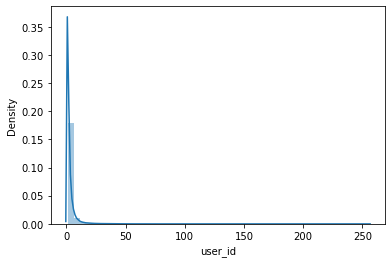

In [12]:
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold 
import lightgbm as lgbm 

sns.distplot(df_tr_te['user_id'].value_counts())

### user_group_id

- user_group_i的分布主要集中在1，2，3，4，5。

<AxesSubplot:>

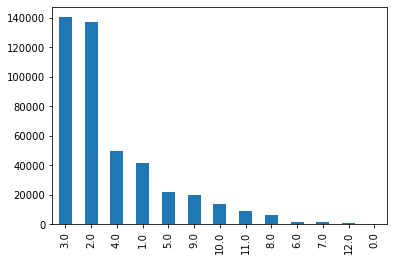

In [16]:
df_tr_te['user_group_id'].value_counts().plot(kind='bar')

### day

- 每天的数据是类似的

<AxesSubplot:>

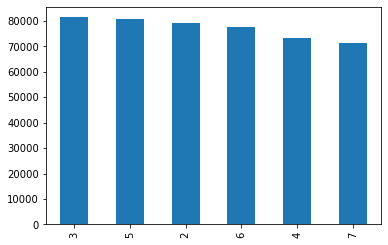

In [6]:
df_tr_te['day'].value_counts().plot(kind = 'bar')

### isClick

- 标签分布有些不平衡；

<AxesSubplot:>

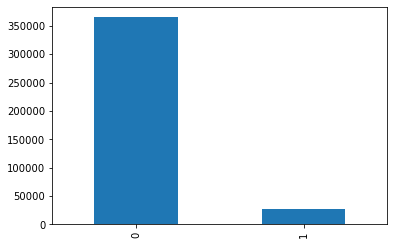

In [15]:
df_tr['isClick'].value_counts().plot(kind = 'bar')


- 每一天用户的点击率会有些许差异，但大致都在0.06-0.075之间。

<AxesSubplot:xlabel='day'>

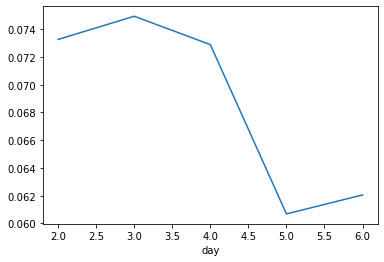

In [10]:
df_tr_te.loc[df_tr_te['isClick']!=-1].groupby('day')['isClick'].mean().plot()

### 小结

从上面的基础分析来看，本次赛题的数据基本符合我们的直观理解。至于其它的细节，大家可以根据自己的需求进行分析。下面我们构建该赛题的Baseline。

## 模型构建
### 特征工程

#### 历史点击率

In [6]:

def _his_click_rate(df, f1, window_size = 2): 
    fea_name = '{}_his_{}_clickrate'.format(f1,window_size )
    df[fea_name] = 0
    for i in tqdm(range(3,8)):
        df_t = df.loc[((df['day'] >= i-window_size) & (df['day'] < i))]
        inds = df['day'] == i
        df.loc[inds,fea_name] = df.loc[inds,f1].map(df_t.groupby(f1)['isClick'].mean()) 
    return df

In [7]:
df_tr_te = _his_click_rate(df = df_tr_te, f1 = 'user_id', window_size = 2)
df_tr_te['gender'] = df_tr_te['gender'].fillna('NAN').map({'Female':1,'Male':0,'NAN':-1})

100%|██████████| 5/5 [00:00<00:00, 13.85it/s]


#### 历史count特征

In [12]:
dense_features = ['user_id_his_2_clickrate']
for c in ['user_id','product','hour','campaign_id','webpage_id','user_group_id','age_level']:
    df_tr_te[c + '_cnt'] = df_tr_te[c].map(df_tr_te[c].value_counts())
    dense_features.append(c + '_cnt')

## 模型训练&预测

### 五折LGB模型

In [13]:
cate_features  = ['user_id','product','hour','campaign_id','webpage_id','user_group_id','age_level']
dense_features = dense_features + ['gender']
label          = 'isClick'

In [35]:

lgb_params = {
      "objective": "binary", 
      "metric": "auc", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 100,
      'learning_rate': 0.01,  
      'colsample_bytree':0.95, 
}
features = cate_features + dense_features
X_tr_val = df_tr_te.loc[df_tr_te['isClick']!=-1] 
X_te     = df_tr_te.loc[df_tr_te['isClick']==-1][features]
 
kf = KFold(n_splits=5)
lgb_models = []
y_pred = 0
for f,(tr_ind,val_ind) in enumerate(kf.split(X_tr_val)):
    
    X_train,X_valid = X_tr_val.iloc[tr_ind][features], X_tr_val.iloc[val_ind][features]
    y_train,y_valid = X_tr_val.iloc[tr_ind][label], X_tr_val.iloc[val_ind][label]
    
    lgbm_train = lgbm.Dataset(X_train,y_train)  
    lgbm_valid = lgbm.Dataset(X_valid,y_valid)

    model_binary = lgbm.train(params=lgb_params, 
                  train_set=lgbm_train,
                  valid_sets=[lgbm_train, lgbm_valid],
                  num_boost_round=100000,   
                  verbose_eval=100,
                  categorical_feature = cate_features)
    y_pred = model_binary.predict(X_te) / 5.0
    lgb_models.append(model_binary)
    

/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['age_level', 'campaign_id', 'hour', 'product', 'user_group_id', 'user_id', 'webpage_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 21190, number of negative: 292270
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19300
[LightGBM] [Info] Number of data points in the train set: 313460, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067600 -> initscore=-2.624149
[LightGBM] [Info] Start training from score -2.624149
Training until validation scores don't improve for 100 rounds


/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/wangrong/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	training's auc: 0.658613	valid_1's auc: 0.602978
[200]	training's auc: 0.668796	valid_1's auc: 0.605539
[300]	training's auc: 0.67614	valid_1's auc: 0.60634
[400]	training's auc: 0.681604	valid_1's auc: 0.606225
Early stopping, best iteration is:
[304]	training's auc: 0.676372	valid_1's auc: 0.606431
[LightGBM] [Info] Number of positive: 21074, number of negative: 292386
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19334
[LightGBM] [Info] Number of data points in the train set: 313460, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067230 -> initscore=-2.630035
[LightGBM] [Info] Start training from score -2.630035
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.65511	valid_1's auc: 0.6083
[200]	training

### 模型提交

In [36]:
sub = pd.DataFrame({'id':df_tr_te.loc[df_tr_te['isClick']==-1]['id'].values, 'isClick':y_pred})
sub.head()

,id,isClick
0,391825,0.026866
1,391826,0.021046
2,391827,0.014573
3,391828,0.011582
4,391829,0.017713


In [37]:
sub.to_csv('baseline_Fold5_lgb.csv',index = None)

# 结论

本文我们对数据进行了简单的分析，同时构建了count和历史点击率两大特征，最终使用5折的交叉LGB进行训练预测。当然本次比赛还有很多其它的提升点，例如：
 
- 细化特征分析，构建其它的特征，包括交叉特征等等；
- 构建现在常见的网络模型，尝试最新的神经网络；
- 使用不同的模型进行融合等等；
